# Sprint 機械学習スクラッチ ロジスティック回帰

## ＜データ読込＞

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# アヤメセットを読み込む
iris_data = load_iris()

# 説明変数
df_X = pd.DataFrame(iris_data.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])


# 目的変数
df_y = pd.DataFrame(iris_data.target, columns=["species"])

df = pd.concat([df_X, df_y], axis=1)

data_X = df.iloc[:,0:4][df["species"] != 0]
data_y = df.iloc[:,4][df["species"] != 0]

X = np.array(data_X)
y = np.array(data_y).reshape(-1,1)

ds_iris={}

# 特徴量は２つに絞る
X = X[:,0:2]
y = y -1

ds_iris["X"] = X
ds_iris["y"] = y

# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


scaler = StandardScaler()
scaler.fit(X_train)
ss_X_train = scaler.transform(X_train)
ss_X_val = scaler.transform(X_val)

In [20]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, lamb = 5, no_bias= False, verbose = True):
        np.set_printoptions(precision=8, suppress=True)
        
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.lamb = lamb
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        y = y.reshape(-1,1)
        
        
        # 学習データと検証データの比率を出す
        if X_val is not None:
            y_val = y_val.reshape(-1,1)
            val_rate = int( X.shape[0] / X_val.shape[0])
        
        # 学習開始        
        # 初期値設定    
        
        # ＜Θの初期値を決定するため、バイアスの有無でＸのshapeを決定＞
        # バイアスありの場合
        if self.no_bias == False:
            # バイアス項 算出
            baias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            
            # バイアス追加
            bias_X = np.hstack([baias, X])
            
            if X_val is not None:
                baias = np.ones(X_val.shape[0]).reshape(X_val.shape[0],1)
                bias_X_val = np.hstack([baias, X_val])
    
        # XのshapeによってΘの要素数を決定
        self.theta = np.random.rand(bias_X.shape[1]).reshape(-1,1)
        self.coef_ = self.theta

        for i in range(self.iter):
            # 推定(1or2を予想するので＋1を印加する)
            y_pred_proba = self.predict_proba(X) 
            print("y_pred_proba = \n{}".format(y_pred_proba))

            # 誤差
            self.loss[i] = self.loss_func(y_pred_proba, y)

            # 最急降下法
            error = y_pred_proba - y
            self.coef_ = self._gradient_descent(bias_X, error)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("〇〇〇学習データ{}回目：loss = {}".format(i+1, self.loss[i]))
              
            # 検証データがセットされた場合
            if X_val is not None:
                
                # 推定
                y_val_pred_proba = self.predict_proba(X_val)

                # ロス関数
                self.val_loss[i] = self.loss_func(y_val_pred_proba, y_val)

                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("★★★検証データ{}回目：loss = {}".format(val_cnt, self.val_loss[i]))

                val_cnt += 1
                
                #return self.coef_

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
        y_pred_proba = self.predict_proba(X)
        threshold = 0.5
        y_pred = np.floor(y_pred_proba + threshold)
        
        return y_pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            # バイアス項 算出
            baias = np.ones(X.shape[0]).reshape(X.shape[0],1)
            
            # バイアス追加
            bias_X = np.hstack([baias, X])  
            
        else:
            bias_X = X

        y_pred_proba = self._hypothesis_func(bias_X)
        
        return y_pred_proba
    
    # シグモイド関数（ロジスティック関数）
    def sigmoid(X):
        z = np.dot(X, self.theta)
        return 1/(1 + np.exp(-z))    
    
    # 【問題1】仮定関数
    def _hypothesis_func(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # 特徴量ベクトル:X
        # パラメータベクトル:乱数生成
        # 特徴量の数:X.shape[1]
        
        # 線形回帰の仮定関数
        z = np.dot(X, self.theta)
        
        # シグモイド関数
        hypothesis = 1/(1 + np.exp(-z))  
        
        return hypothesis

    
    # 【問題2】最急降下法
    def _gradient_descent(self, X, error):
        """
        最急降下法を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        error : 計算した誤差

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
              
        # バイアスありの場合
        if self.no_bias == False:
            # ＮＧルート
            if True:
                # j = 0 の場合
                self.theta[0] = self.theta[0] - (self.lr / X.shape[0]) * (np.dot(X[:,0].T, error))  

                # j ≧ 1 の場合
                self.theta[1:] = self.theta[1:] - self.lr * ( ((1/ X.shape[0]) * np.dot(X[:,1:].T, error)) + \
                (self.lamb/X.shape[0]) * self.theta[1:] ) 
            
            '''
            # 別解
            else:
                # 全領域に正則化以外の項を適用
                self.theta = self.theta - (self.lr / X.shape[0]) * (np.dot(X.T, error)) 
                
                # J ≧ 1 の項に正則化項を適用
                self.theta[1:] = self.theta[1:] - self.lr *( (self.lamb/X.shape[0]) * self.theta[1:] )
            '''
            
            
        # バイアス無しの場合
        else:
            self.theta = self.theta - (self.lr / X.shape[0]) * (np.dot(X.T, error)) + (self.lamb/X.shape[0]) * self.theta 
            
        return self.theta
    
    
    def loss_func(self, y_pred_proba, y):
            
        loss = (((-np.log(y_pred_proba)*y)) \
                + (-np.log(1-y_pred_proba)*(1-y))).mean() / X.shape[1]  \
                + self.lamb / (2 * X.shape[1]) * sum(self.theta**2)
            
        return loss    
    

## 【問題5】学習と推定

In [21]:
ScratchLR = ScratchLogisticRegression(num_iter = 1000, lr = 0.08, lamb = 0, no_bias = False, verbose = True)

# 学習開始
clf = ScratchLR.fit(ss_X_train, y_train, ss_X_val, y_val)


bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.85438665]
 [0.50043213]
 [0.17799684]
 [0.80310273]
 [0.85858259]
 [0.43475948]
 [0.87403834]
 [0.8026323 ]
 [0.65440546]
 [0.72530358]
 [0.79208256]
 [0.43549005]
 [0.37060608]
 [0.77523015]
 [0.76922583]
 [0.66141953]
 [0.50043213]
 [0.97346593]
 [0.55988476]
 [0.71784831]
 [0.73205261]
 [0.63880584]
 [0.85438665]
 [0.46782483]
 [0.55915221]
 [0.76869777]
 [0.3040803 ]
 [0.49264124]
 [0.34772389]
 [0.61555967]
 [0.76922583]
 [0.60815838]
 [0.23805409]
 [0.72589538]
 [0.86267706]
 [0.49264124]
 [0.32552379]
 [0.76311013]
 [0.14256279]
 [0.64664469]
 [0.705054  ]
 [0.90090119]
 [0.8278614 ]
 [0.705054  ]
 [0.49264124]
 [0.59928032]
 [0.7747118 ]
 [0.89781143]
 [0.7747118 ]
 [0.7806141 ]
 [0.86267706]
 [0.60815838]
 [0.19301505]
 [0.86267706]
 [0.93543388]
 [0.66902189]
 [0.42638974]
 [0.32552379]
 [0.50191827]
 [0.45087035]
 [0.93137576]
 [0.47559114]
 [0.89463659]
 [0.53377552]
 [0.93909789]
 [0.88136524]
 [0.69790556]
 [0.8

 [0.38044914]]
(更新前)self.theta[0] = [0.34741698]
(更新後)self.theta[0] = [0.34270147]
(更新後)self.theta = 
[[0.34270147]
 [1.06502795]
 [0.38059553]]
〇〇〇学習データ58回目：loss = 0.26945746656499786
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ58回目：loss = 0.31872451593186285
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.81980556]
 [0.34783947]
 [0.07827858]
 [0.75023034]
 [0.82673266]
 [0.28332292]
 [0.84889515]
 [0.74510954]
 [0.54179217]
 [0.63697945]
 [0.73196424]
 [0.28886676]
 [0.22189275]
 [0.70866521]
 [0.69873792]
 [0.54686968]
 [0.34783947]
 [0.97649364]
 [0.42672032]
 [0.61952184]
 [0.64791637]
 [0.51807454]
 [0.81980556]
 [0.31762196]
 [0.42009372]
 [0.69299343]
 [0.16773388]
 [0.34321022]
 [0.20255985]
 [0.48915883]
 [0.69873792]
 [0.48404476]
 [0.11674357]
 [0.64323245]
 [0.83344757]
 [0.34321022]
 [0.18451196]
 [0.68862099]
 [0.05921959]
 [0.52995026]
 [0.60982503]
 [0.88891814]
 [0.78306678]
 [0.60982503]
 [0.34321022]
 [0.46540501]
 [0.70302956]
 [0.88412872]
 [0.7

y_pred_proba = 
[[0.79656225]
 [0.28166009]
 [0.05386732]
 [0.72601963]
 [0.80680896]
 [0.22918042]
 [0.83307669]
 [0.70989124]
 [0.49247052]
 [0.59278899]
 [0.69964256]
 [0.24355628]
 [0.17231443]
 [0.67521652]
 [0.66092354]
 [0.48867125]
 [0.28166009]
 [0.97623274]
 [0.38107051]
 [0.55758834]
 [0.60825168]
 [0.46032249]
 [0.79656225]
 [0.26216213]
 [0.36246722]
 [0.64284822]
 [0.12892722]
 [0.28474618]
 [0.15669412]
 [0.43222814]
 [0.66092354]
 [0.43596273]
 [0.08349587]
 [0.61186815]
 [0.81665835]
 [0.28474618]
 [0.14224644]
 [0.64633102]
 [0.04138537]
 [0.47637203]
 [0.56507511]
 [0.88530173]
 [0.75722068]
 [0.56507511]
 [0.28474618]
 [0.40090627]
 [0.65750829]
 [0.87859174]
 [0.65750829]
 [0.67187376]
 [0.81665835]
 [0.43596273]
 [0.05996607]
 [0.81665835]
 [0.93260649]
 [0.5047847 ]
 [0.21799194]
 [0.14224644]
 [0.31498571]
 [0.2379983 ]
 [0.92944368]
 [0.2592321 ]
 [0.87154617]
 [0.31906803]
 [0.93067015]
 [0.85024392]
 [0.54917135]
 [0.75722068]
 [0.53694843]
 [0.76887398]
 [0.

 [0.89350355]]
(更新前)self.theta = 
[[0.06859854]
 [1.21399821]
 [0.35895747]]
(更新前)self.theta[0] = [0.06859854]
(更新後)self.theta[0] = [0.06810698]
(更新後)self.theta = 
[[0.06810698]
 [1.21448616]
 [0.35877495]]
〇〇〇学習データ207回目：loss = 0.2638005666568974
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ207回目：loss = 0.3188291045771176
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78666414]
 [0.25524134]
 [0.04613724]
 [0.72027579]
 [0.79932817]
 [0.21067081]
 [0.82754617]
 [0.69495688]
 [0.47641477]
 [0.57687526]
 [0.68815247]
 [0.23175048]
 [0.155335  ]
 [0.66428047]
 [0.6468591 ]
 [0.46513733]
 [0.25524134]
 [0.97616831]
 [0.37035793]
 [0.52756169]
 [0.59559066]
 [0.43813242]
 [0.78666414]
 [0.24330361]
 [0.34228793]
 [0.61841544]
 [0.1170612 ]
 [0.26394107]
 [0.14155629]
 [0.41148916]
 [0.6468591 ]
 [0.42249334]
 [0.07260388]
 [0.60644481]
 [0.81142065]
 [0.26394107]
 [0.1288134 ]
 [0.62903854]
 [0.03630094]
 [0.45721043]
 [0.55005461]
 [0.88727843]
 [0.74777835]
 [0.55005461]

(更新前)self.theta[0] = [0.04375544]
(更新後)self.theta[0] = [0.04364176]
(更新後)self.theta = 
[[0.04364176]
 [1.24807134]
 [0.34426616]]
〇〇〇学習データ302回目：loss = 0.2636615677311254
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ302回目：loss = 0.3191613963227484
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78282259]
 [0.2428694 ]
 [0.04291597]
 [0.72117377]
 [0.79720549]
 [0.20354961]
 [0.82639698]
 [0.68885355]
 [0.47220631]
 [0.5718515 ]
 [0.68499775]
 [0.22992606]
 [0.14842287]
 [0.66199086]
 [0.64232072]
 [0.45509927]
 [0.2428694 ]
 [0.9763238 ]
 [0.37053615]
 [0.51178659]
 [0.59294107]
 [0.42929085]
 [0.78282259]
 [0.23633655]
 [0.33504739]
 [0.60585567]
 [0.11294604]
 [0.255743  ]
 [0.13567558]
 [0.40386125]
 [0.64232072]
 [0.42052869]
 [0.06803831]
 [0.60943446]
 [0.810866  ]
 [0.255743  ]
 [0.12386384]
 [0.62215924]
 [0.03449322]
 [0.45065681]
 [0.54605713]
 [0.89076703]
 [0.74514376]
 [0.54605713]
 [0.255743  ]
 [0.36288652]
 [0.62636466]
 [0.88203796]
 [0.62636466]
 [0.64

(更新前)self.theta[0] = [0.03907598]
(更新後)self.theta[0] = [0.03903848]
(更新後)self.theta = 
[[0.03903848]
 [1.26176369]
 [0.33718394]]
〇〇〇学習データ369回目：loss = 0.2636366616621704
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ369回目：loss = 0.31919785285353847
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78189417]
 [0.23883058]
 [0.04194619]
 [0.72266177]
 [0.79701144]
 [0.20171126]
 [0.82652603]
 [0.68724403]
 [0.47197376]
 [0.57108268]
 [0.68476183]
 [0.23055221]
 [0.14646477]
 [0.66222796]
 [0.64158685]
 [0.45222632]
 [0.23883058]
 [0.97643402]
 [0.37232894]
 [0.5062127 ]
 [0.59320972]
 [0.42698   ]
 [0.78189417]
 [0.23466608]
 [0.33343809]
 [0.60152442]
 [0.11203571]
 [0.25357327]
 [0.13410903]
 [0.40210848]
 [0.64158685]
 [0.42135083]
 [0.06666752]
 [0.61223272]
 [0.81133374]
 [0.25357327]
 [0.12264584]
 [0.6204074 ]
 [0.0340577 ]
 [0.44937333]
 [0.5458126 ]
 [0.89269886]
 [0.74492597]
 [0.5458126 ]
 [0.25357327]
 [0.35924368]
 [0.62311743]
 [0.88366762]
 [0.62311743]
 [0.6

★★★検証データ460回目：loss = 0.31917563122314474
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78137234]
 [0.23584717]
 [0.04126957]
 [0.72437168]
 [0.79711978]
 [0.20061106]
 [0.82687379]
 [0.68625381]
 [0.47240479]
 [0.57097195]
 [0.68499786]
 [0.23167248]
 [0.14517416]
 [0.6629128 ]
 [0.64143416]
 [0.45032101]
 [0.23584717]
 [0.97654126]
 [0.37457697]
 [0.50188051]
 [0.5939998 ]
 [0.42557992]
 [0.78137234]
 [0.23375335]
 [0.33265102]
 [0.59820851]
 [0.11159346]
 [0.2522396 ]
 [0.13313748]
 [0.40120599]
 [0.64143416]
 [0.4227335 ]
 [0.06571428]
 [0.61524315]
 [0.81200586]
 [0.2522396 ]
 [0.12195641]
 [0.61937275]
 [0.0338173 ]
 [0.44887909]
 [0.54618877]
 [0.8945141 ]
 [0.74509347]
 [0.54618877]
 [0.2522396 ]
 [0.35666749]
 [0.62074549]
 [0.88523797]
 [0.62074549]
 [0.64277323]
 [0.81200586]
 [0.4227335 ]
 [0.04543599]
 [0.81200586]
 [0.93873108]
 [0.47385731]
 [0.18585266]
 [0.12195641]
 [0.30822996]
 [0.20154713]
 [0.93839509]
 [0.21821171]
 [0.87525988]
 [0.27282397]
 [0.92

★★★検証データ545回目：loss = 0.3191434365067411
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78116654]
 [0.23433274]
 [0.0409422 ]
 [0.72547276]
 [0.79726803]
 [0.20015488]
 [0.82714376]
 [0.68582447]
 [0.47285902]
 [0.57109201]
 [0.6852738 ]
 [0.23250442]
 [0.14458108]
 [0.66345566]
 [0.64150524]
 [0.44943715]
 [0.23433274]
 [0.97660397]
 [0.37608384]
 [0.49959399]
 [0.59462942]
 [0.42498839]
 [0.78116654]
 [0.23341734]
 [0.33240956]
 [0.5964753 ]
 [0.11146131]
 [0.25166889]
 [0.1327184 ]
 [0.40090116]
 [0.64150524]
 [0.42374038]
 [0.0652543 ]
 [0.61713635]
 [0.81246921]
 [0.25166889]
 [0.12169058]
 [0.61894542]
 [0.03372819]
 [0.44880515]
 [0.54659556]
 [0.89557956]
 [0.74530197]
 [0.54659556]
 [0.25166889]
 [0.35540384]
 [0.61954772]
 [0.88617142]
 [0.61954772]
 [0.64209249]
 [0.81246921]
 [0.42374038]
 [0.0450276 ]
 [0.81246921]
 [0.93935956]
 [0.4734958 ]
 [0.18510207]
 [0.12169058]
 [0.30964077]
 [0.20056415]
 [0.93921389]
 [0.21697391]
 [0.87603296]
 [0.27134812]
 [0.927

 [0.89632929]]
(更新前)self.theta = 
[[0.03742789]
 [1.28323384]
 [0.32465079]]
(更新前)self.theta[0] = [0.03742789]
(更新後)self.theta[0] = [0.03742984]
(更新後)self.theta = 
[[0.03742984]
 [1.28326999]
 [0.32462832]]
〇〇〇学習データ626回目：loss = 0.26361850894032357
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ626回目：loss = 0.3191186853655974
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78106663]
 [0.23347839]
 [0.04076267]
 [0.7261627 ]
 [0.79737826]
 [0.19992881]
 [0.82732274]
 [0.68560282]
 [0.47318611]
 [0.57121202]
 [0.68547523]
 [0.23305497]
 [0.14426561]
 [0.66381959]
 [0.64158893]
 [0.44896289]
 [0.23347839]
 [0.97664133]
 [0.37704568]
 [0.49827603]
 [0.59505271]
 [0.42469014]
 [0.78106663]
 [0.23326661]
 [0.33232116]
 [0.5954805 ]
 [0.11141531]
 [0.25137921]
 [0.13250481]
 [0.40077522]
 [0.64158893]
 [0.42440094]
 [0.06500238]
 [0.6183136 ]
 [0.81276591]
 [0.25137921]
 [0.12156657]
 [0.61873255]
 [0.03368824]
 [0.44881647]
 [0.54688951]
 [0.89622196]
 [0.74545534]
 [0.54688951

 [0.89652569]]
(更新前)self.theta = 
[[0.03759482]
 [1.28582803]
 [0.32302852]]
(更新前)self.theta[0] = [0.03759482]
(更新後)self.theta[0] = [0.03759641]
(更新後)self.theta = 
[[0.03759641]
 [1.28584942]
 [0.32301507]]
〇〇〇学習データ718回目：loss = 0.2636178585590951
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ718回目：loss = 0.31909940195072367
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78100431]
 [0.23289831]
 [0.04064279]
 [0.72665622]
 [0.79746251]
 [0.19978699]
 [0.82745371]
 [0.68545945]
 [0.47343439]
 [0.5713126 ]
 [0.68562857]
 [0.23345943]
 [0.14405859]
 [0.66408772]
 [0.64166154]
 [0.44864962]
 [0.23289831]
 [0.9766673 ]
 [0.37774064]
 [0.49737014]
 [0.59536512]
 [0.42450056]
 [0.78100431]
 [0.23317875]
 [0.33227886]
 [0.594798  ]
 [0.11139486]
 [0.2511945 ]
 [0.13236837]
 [0.40070665]
 [0.64166154]
 [0.42488392]
 [0.06483425]
 [0.61915317]
 [0.81298001]
 [0.2511945 ]
 [0.12149215]
 [0.61859804]
 [0.03366503]
 [0.44884369]
 [0.5471128 ]
 [0.89667278]
 [0.74557229]
 [0.5471128 

 [0.89663221]]
(更新前)self.theta = 
[[0.03770462]
 [1.28722103]
 [0.32215031]]
(更新前)self.theta[0] = [0.03770462]
(更新後)self.theta[0] = [0.03770575]
(更新後)self.theta = 
[[0.03770575]
 [1.28723455]
 [0.32214177]]
〇〇〇学習データ799回目：loss = 0.2636176453407631
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ799回目：loss = 0.3190884746772446
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78097265]
 [0.23259026]
 [0.04057971]
 [0.72692522]
 [0.79750979]
 [0.19971494]
 [0.82752583]
 [0.68538518]
 [0.47357355]
 [0.57137129]
 [0.68571455]
 [0.23368291]
 [0.14395066]
 [0.66423592]
 [0.64170443]
 [0.4484856 ]
 [0.23259026]
 [0.97668123]
 [0.37812152]
 [0.49688581]
 [0.59553796]
 [0.42440343]
 [0.78097265]
 [0.23313614]
 [0.33226133]
 [0.59443339]
 [0.11138703]
 [0.25109975]
 [0.13229832]
 [0.40067493]
 [0.64170443]
 [0.42515009]
 [0.0647458 ]
 [0.61961023]
 [0.81309715]
 [0.25109975]
 [0.12145538]
 [0.61852929]
 [0.03365382]
 [0.44886355]
 [0.54723795]
 [0.89691612]
 [0.74563789]
 [0.54723795]

bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78095096]
 [0.23237471]
 [0.04053577]
 [0.72711575]
 [0.79754372]
 [0.19966561]
 [0.82757713]
 [0.68533382]
 [0.47367337]
 [0.57141411]
 [0.68577623]
 [0.23384224]
 [0.14387581]
 [0.66434156]
 [0.64173588]
 [0.4483716 ]
 [0.23237471]
 [0.97669102]
 [0.37839205]
 [0.49654576]
 [0.59566122]
 [0.42433664]
 [0.78095096]
 [0.23310767]
 [0.33225071]
 [0.59417748]
 [0.11138257]
 [0.25103455]
 [0.13225011]
 [0.40065429]
 [0.64173588]
 [0.42533959]
 [0.0646842 ]
 [0.6199338 ]
 [0.81318027]
 [0.25103455]
 [0.12143057]
 [0.61848208]
 [0.03364635]
 [0.44887926]
 [0.54732772]
 [0.89708765]
 [0.74568495]
 [0.54732772]
 [0.25103455]
 [0.35381045]
 [0.6179977 ]
 [0.88750246]
 [0.6179977 ]
 [0.6412639 ]
 [0.81318027]
 [0.42533959]
 [0.04451272]
 [0.81318027]
 [0.94024247]
 [0.47316175]
 [0.18419482]
 [0.12143057]
 [0.3118119 ]
 [0.19933786]
 [0.94035767]
 [0.21539714]
 [0.87714677]
 [0.26945078]
 [0.92771755]
 [0.85422674]
 [0.52250562]
 [0.7

 [0.89674871]]
(更新前)self.theta = 
[[0.0378362 ]
 [1.28873669]
 [0.32119044]]
(更新前)self.theta[0] = [0.0378362]
(更新後)self.theta[0] = [0.03783665]
(更新後)self.theta = 
[[0.03783665]
 [1.28874166]
 [0.32118728]]
〇〇〇学習データ976回目：loss = 0.26361752208594386
bias_X.shape = (25, 3)
X.shape = (25, 3)
★★★検証データ976回目：loss = 0.31907625789464683
bias_X.shape = (75, 3)
X.shape = (75, 3)
y_pred_proba = 
[[0.78093926]
 [0.23225721]
 [0.04051188]
 [0.72722025]
 [0.79756245]
 [0.19963902]
 [0.82760534]
 [0.68530599]
 [0.47372847]
 [0.57143794]
 [0.68581028]
 [0.23392993]
 [0.1438352 ]
 [0.66439969]
 [0.64175343]
 [0.44830967]
 [0.23225721]
 [0.97669637]
 [0.37854066]
 [0.49636006]
 [0.59572906]
 [0.42430055]
 [0.78093926]
 [0.23309252]
 [0.33224537]
 [0.59403774]
 [0.11138042]
 [0.25099931]
 [0.13222405]
 [0.40064348]
 [0.64175343]
 [0.42544381]
 [0.0646507 ]
 [0.62011122]
 [0.81322589]
 [0.25099931]
 [0.1214173 ]
 [0.61845658]
 [0.03364238]
 [0.44888832]
 [0.54737727]
 [0.89718148]
 [0.74571093]
 [0.54737727

In [4]:
import pandas as pd
from sklearn.metrics import classification_report

y_pred_proba = ScratchLR.predict(ss_X_val)
print("ss_X_val.shape = {}".format(ss_X_val.shape))
print("y_pred_proba.shape = {}".format(y_pred_proba.shape))
target_names = [iris_data.target_names[1], iris_data.target_names[2]]
cr = classification_report(y_val.flatten(), y_pred_proba.flatten(), target_names = target_names, output_dict=True)
#print(cr)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

bias_X.shape = (25, 3)
X.shape = (25, 3)
ss_X_val.shape = (25, 2)
y_pred_proba.shape = (25, 1)


,versicolor,virginica,accuracy,macro avg,weighted avg
precision,0.625000,0.666667,0.64,0.645833,0.645000
recall,0.769231,0.500000,0.64,0.634615,0.640000
f1-score,0.689655,0.571429,0.64,0.630542,0.632906
support,13.000000,12.000000,0.64,25.000000,25.000000


## 【問題6】学習曲線のプロット

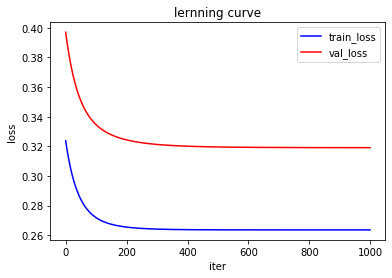

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ScratchLR.loss)), ScratchLR.loss, color='blue', label='train_loss')
plt.plot(range(len(ScratchLR.val_loss)), ScratchLR.val_loss, color='red', label='val_loss')
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("lernning curve")
plt.legend()
plt.show()

## 【問題1】仮定関数

```python
    # 線形回帰の仮定関数
    z = np.dot(X, self.theta)

    # シグモイド関数
    hypothesis = 1/(1 + np.exp(-z))  
```

## 【問題2】最急降下法

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}------①\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}   ,j = 0　--------②\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　  ,j\geq 1---------③\\
\theta_0 := \theta_0 - \alpha \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_0^{(i)}　  ,j = 0\\
\theta_j := \theta_j - \alpha \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　  ,j\geq 1\\
$$

## 【問題3】推定

```python
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        y_pred_proba = self._hypothesis_func(X)
        
        return y_pred_proba
```

```python
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        threshold = 0.5
        y_pred_proba = self._hypothesis_func(X)
        y_pred = np.floor(y_pred_proba + threshold)
        return y_pred
```

## 【問題4】目的関数

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$

```python
    def loss_func(self, y_pred, y):
        
        #loss  = MSE(y_pred, y) / 2
        loss = (1/y_pred.shape[0]) * ((-y * np.log(y_pred)) - (1 - y) * np.log(1-y_pred)) + \
            (self.lamb/(2 * y_pred.shape[0])) * np.square(self.theta)
        
        return loss  
```

## 【問題7】決定領域の可視化

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    print("<<decision_region>>")
    
    print("X.shape = {}".format(X.shape))
    print("X.shape = {}".format(y.shape))
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), \
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    print("mesh.shape = {}".format(mesh.shape))
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], \
                    label=target_names[i], marker='o')
        
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

<<decision_region>>
X.shape = (75, 2)
X.shape = (75,)
mesh.shape = (343440, 2)
bias_X.shape = (343440, 3)
X.shape = (343440, 3)


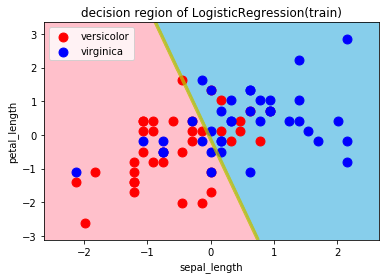

In [7]:
# 可視化
decision_region(ss_X_train, y_train.flatten(), ScratchLR, title='decision region of LogisticRegression(train)', xlabel='sepal_length', ylabel='petal_length')

<<decision_region>>
X.shape = (25, 2)
X.shape = (25,)
mesh.shape = (319915, 2)
bias_X.shape = (319915, 3)
X.shape = (319915, 3)


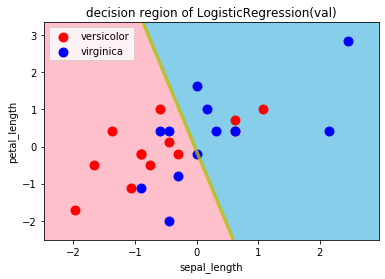

In [8]:
# 可視化
decision_region(ss_X_val, y_val.flatten(), ScratchLR, title='decision region of LogisticRegression(val)', xlabel='sepal_length', ylabel='petal_length')

### sklearnと比較

C:\Users\Takatoshi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,versicolor,virginica,accuracy,macro avg,weighted avg
precision,0.625000,0.666667,0.64,0.645833,0.645000
recall,0.769231,0.500000,0.64,0.634615,0.640000
f1-score,0.689655,0.571429,0.64,0.630542,0.632906
support,13.000000,12.000000,0.64,25.000000,25.000000


<<decision_region>>
X.shape = (75, 2)
X.shape = (75,)
mesh.shape = (343440, 2)


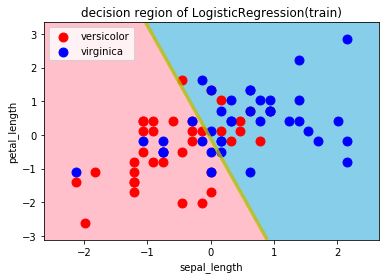

In [9]:
from sklearn.linear_model import LogisticRegression
# 学習
model_LR = LogisticRegression()
clf = model_LR.fit(ss_X_train, y_train)

# 推定
y_pred_LR = model_LR.predict(ss_X_val)

# 評価
target_names = [iris_data.target_names[1], iris_data.target_names[2]]
cr_LR = classification_report(y_val, y_pred_LR, target_names = target_names, output_dict=True)

# pandas.DataFrameへ変換
df_cr_LR = pd.DataFrame(cr_LR)
display(df_cr_LR)

# 可視化
decision_region(ss_X_train, y_train.flatten(), clf, title='decision region of LogisticRegression(train)', xlabel='sepal_length', ylabel='petal_length')

<<decision_region>>
X.shape = (25, 2)
X.shape = (25,)
mesh.shape = (319915, 2)


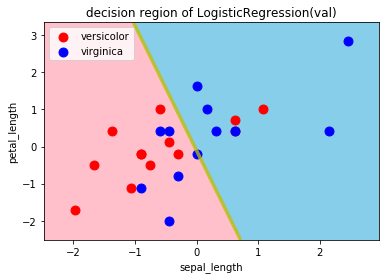

In [10]:
# 可視化
decision_region(ss_X_val, y_val.flatten(), clf, title='decision region of LogisticRegression(val)', xlabel='sepal_length', ylabel='petal_length')

## 【問題8】（アドバンス課題）重みの保存

### ScratchLR.coef_の書込み

In [11]:
import pickle
print("coef_ =\n{}".format(ScratchLR.coef_))
with open('sprint4_coef.pkl', 'wb') as pkl:
    pickle.dump(ScratchLR.coef_, pkl)

coef_ =
[[0.03766981]
 [1.28693366]
 [0.32234128]]


### ScratchLR.coef_の読込み

In [12]:
with open('sprint4_coef.pkl', 'rb') as pkl:
    # 別変数にロード
    load_test = pickle.load(pkl)
    print("coef_ =\n{}".format(load_test))


coef_ =
[[0.03766981]
 [1.28693366]
 [0.32234128]]


### np.savezを使ってみる

In [17]:
np.savez('sprint4_coef.npz', coef = ScratchLR.coef_)

In [18]:
npz = np.load('sprint4_coef.npz')

In [19]:
print(npz.files)

['coef']
